In [185]:
# Imports
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [186]:
data = pd.read_csv("titanic.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [187]:
print(data.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [188]:
# Fill in missing ages
def fill_missing_ages(df):
    age_fill_map = {}
    for pclass in df["Pclass"].unique():
        if pclass not in age_fill_map:
            age_fill_map[pclass] = df[df["Pclass"] == pclass]["Age"].median()

    df["Age"] = df.apply(lambda row: age_fill_map[row["Pclass"]] if pd.isnull(row["Age"]) else row["Age"], axis=1)

In [189]:
# Data Cleaning and Feature Engineering
def preprocess_data(df):
    df.drop(columns=["PassengerId", "Name", "Ticket","Cabin"], inplace=True)

    df["Embarked"].fillna("S", inplace=True)
    df.drop(columns=["Embarked"], inplace=True)

    fill_missing_ages(df)

    # Convert Gender
    df["Sex"] = df["Sex"].map({'male':1,"female":0})

    # Feature Enginnering
    df["FamilySize"] = df["SibSp"] + df["Parch"]
    df["IsAlone"] = np.where(df["FamilySize"] == 0, 1, 0)
    df["FareBin"] = pd.qcut(df["Fare"], 4, labels=False)
    df["AgeBin"] = pd.cut(df["Age"], bins=[0,12,20,40,60, np.inf],labels=False)

    return df

In [190]:
data = preprocess_data(data)

C:\Users\PC\AppData\Local\Temp\ipykernel_23168\2189919927.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Embarked"].fillna("S", inplace=True)


In [191]:
# Create Features / Target Variables (Make Flashcards)
X = data.drop(columns=["Survived"])
y = data["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [192]:
# ML Preprocessing
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [193]:
# Hyperparemeter Tuning - KNN

def tune_model(X_train, y_train):
    param_grid = {
        "n_neighbors":range(1,21),
        "metric" : ["euclidean", "manhattan", "minkowski"],
        "weights" : ["uniform","distance"]
    }

    model = KNeighborsClassifier()
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=1)
    grid_search.fit(X_train, y_train)

    return grid_search.best_estimator_
# pip install -U scikit-learn joblib ------ if error occurs


In [194]:

best_model = tune_model(X_train, y_train)

In [195]:
# Predictions and evaulate
def evaluate_model(model, X_test, y_test):
    prediction = model.predict(X_test)
    accuracy = accuracy_score(y_test, prediction)
    matrix = confusion_matrix(y_test, prediction)
    return accuracy, matrix

accuracy, matrix = evaluate_model(best_model, X_test, y_test)

print(f'Accuracy: {accuracy*100:.2f}%')
print(f'Confusion Matrix:')
print(matrix)

Accuracy: 80.27%
Confusion Matrix:
[[115  19]
 [ 25  64]]


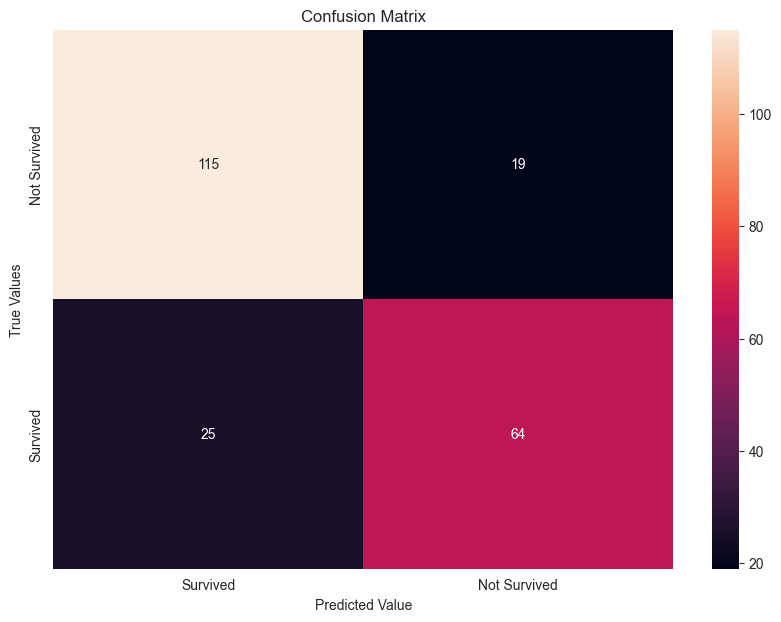

In [196]:
# Plot
def plot_model(matrix):
    plt.figure(figsize=(10,7))
    sns.heatmap(matrix, annot=True, fmt="d", xticklabels=["Survived","Not Survived"], yticklabels=["Not Survived", "Survived"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Value")
    plt.ylabel("True Values")
    plt.show()


plot_model(matrix)
